# M1 useful nodes
This notebook identifies M1 nodes (attention heads and MLPs) that, when ablated, cause a decrease in model prediction accuracy. These nodes are needed (aka useful) for accurate predictions.


This notebook was:
- Developed on Google Colab using an **T4**
- Runs with M1 (TinyStories) with base/CS1/CS2/CS3.
- Requires a GITHUB_TOKEN secret to access Martian quanta_text_to_sql code repository.
- Requires a HF_TOKEN secret to access Martian HuggingFace repository.

This notebook relies on the nnsight library. Useful background:
- https://nnsight.net/notebooks/tutorials/walkthrough/#Batching
- https://nnsight.net/notebooks/tutorials/walkthrough/#Looping

This notebook relies on the https://github.com/PhilipQuirke/quanta_mech_interp library for graphing useful nodes.

# Import libraries
Imports standard libraries. Do not read.

In [ ]:
# https://nnsight.net/
# Access 0.4 prerelease version (as at Dec 2024)
#!pip install nnsight==0.4.0.dev0
!pip install -U nnsight

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 81.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.2/76.2 kB 7.3 MB/s eta 0:00:00


In [ ]:
from IPython.display import clear_output
import einops
import torch
import numpy as np
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "colab"
import matplotlib.pyplot as plt
import tqdm.auto as tqdm

import nnsight
from nnsight import LanguageModel

In [ ]:
from getpass import getpass
from google.colab import userdata
import gc
import weakref

In [ ]:
!pip install --upgrade git+https://github.com/PhilipQuirke/quanta_mech_interp.git
import QuantaMechInterp as qmi

  Cloning https://github.com/PhilipQuirke/quanta_mech_interp.git to /tmp/pip-req-build-ecwbmrox
  Running command git clone --filter=blob:none --quiet https://github.com/PhilipQuirke/quanta_mech_interp.git /tmp/pip-req-build-ecwbmrox
  Resolved https://github.com/PhilipQuirke/quanta_mech_interp.git to commit ae021222e0a88ef87d38ac90d72987116e64646a
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
INFO: pip is looking at multiple versions of torchtyping to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 9.8 MB/s eta 0:00:00
  Created wheel for QuantaMechInterp: filename=QuantaMechInterp-1.0-py3-none-any.whl size=39768 sha256=7841cc6585e91112225156291e4a5aeaaa2f8116c2c96f2b92f621ac81657cfb
  Stored in directory: /tmp/pip-ephem-wheel-cache-rz7pzq1u/wheels/0f/d1/c3/1763b9cf263825f6202103985dba1535762cf43b87d

In [ ]:
github_token = userdata.get("GITHUB_TOKEN")

# Install the private repository using the token
!pip install --upgrade git+https://{github_token}@github.com/withmartian/quanta_text_to_sql.git

import QuantaTextToSql as qts

  Cloning https://****@github.com/withmartian/quanta_text_to_sql.git to /tmp/pip-req-build-dcm6gw1p
  Running command git clone --filter=blob:none --quiet 'https://****@github.com/withmartian/quanta_text_to_sql.git' /tmp/pip-req-build-dcm6gw1p
  Resolved https://****@github.com/withmartian/quanta_text_to_sql.git to commit 720af36fcccc330cda849a509c8e18a028f6db4f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for QuantaTextToSql: filename=QuantaTextToSql-1.0-py3-none-any.whl size=42241 sha256=0531f349e2d51309dde4b9370ad240007125abf86e1db5700d84ce1e35095786
  Stored in directory: /tmp/pip-ephem-wheel-cache-ez5ifq6f/wheels/ec/2e/0b/f2473c76d3035232d5580b15e3979fcc34fe1494a4d6ac8cc9
Successfully built QuantaTextToSql


# Select model, command set and feature to investigate


In [ ]:
model_num = 1                 # 1=TinyStories, 2=Qwen, 3=Llama, 4=Granite, 5=SmolLM
cs_num = 1                    # 0=BaseModel, 1=CS1, 2=CS2 or 3=CS3

# Load model

In [ ]:
model_hf_name = qts.sql_interp_model_location(model_num, cs_num)

if model_num == 1:
    the_tokenizer, the_model = qts.load_sql_interp_model(model_num, cs_num, auth_token=userdata.get("HF_TOKEN"), use_flash_attention=False)
    model = LanguageModel(the_model, the_tokenizer)
    model.tokenizer = the_tokenizer
else:
    model = LanguageModel(model_hf_name, device_map="auto")

clear_output()
print(model)

GPTNeoForCausalLM(
  (transformer): GPTNeoModel(
    (wte): Embedding(50258, 1024)
    (wpe): Embedding(2048, 1024)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-1): 2 x GPTNeoBlock(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPTNeoAttention(
          (attention): GPTNeoSelfAttention(
            (attn_dropout): Dropout(p=0.0, inplace=False)
            (resid_dropout): Dropout(p=0.0, inplace=False)
            (k_proj): Linear(in_features=1024, out_features=1024, bias=False)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=False)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=False)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPTNeoMLP(
          (c_fc): Linear(in_features=1024, out_features=4096, bias=True)
          (c_proj): L

In [ ]:
if model_num == 1:
    N_LAYERS = len(model.transformer.h)
else:
    N_LAYERS = len(model.model.layers)
N_HEADS = 16 if model_num == 1 else 7 if model_num == 2 else 16
D_MODEL = model.transformer.wte.embedding_dim if model_num == 1 else model.config.hidden_size
D_HEAD = D_MODEL // N_HEADS

print("N_LAYERS="+str(N_LAYERS), "N_HEADS="+str(N_HEADS), "D_MODEL="+str(D_MODEL), "D_HEAD="+str(D_HEAD))

N_LAYERS=2 N_HEADS=16 D_MODEL=1024 D_HEAD=64


In [ ]:
# Singleton QuantaTool "main" configuration class. qmi.AlgoConfig is derived from the chain qmi.UsefulConfig > qmi.ModelConfig
cfg = qmi.AlgoConfig()
cfg.repo_name, cfg.model_name = model_hf_name.rsplit("/", 1)
cfg.main_model = model
cfg.n_layers = N_LAYERS
cfg.n_heads = N_HEADS
cfg.d_model = D_MODEL
cfg.d_head = D_HEAD
cfg.file_config_prefix = ""

print("cfg.repo_name="+cfg.repo_name, "cfg.model_name="+cfg.model_name)

# Generate test data and experiment runs

In [ ]:
# Generate a batch of prompts with 3 field names
def generate_batch(batch_size):
    cfg.batch_size = N_BATCH

    if cs_num == 0 or cs_num == 1:
      examples = qts.generate_cs1(batch_size=N_BATCH, min_cols=3, max_cols=3)
    elif cs_num == 2:
      examples = qts.generate_cs2(batch_size=N_BATCH, min_cols=3, max_cols=3)
    elif cs_num == 3:
      examples = qts.generate_cs3(batch_size=N_BATCH, min_cols=3, max_cols=3)

    return examples

In [ ]:
# Return a list of experiments to run. Also the max num tokens in the prompts, the
# max num tokens in the (ground truth) answer, and max num tokens in prompt+answer.
def get_experiment_list(examples, by_attention_head):
    run_list = []
    max_prompt_tokens = 0
    max_good_answer_tokens = 0
    max_tokens = 0

    for example in examples:
        prompt = example.get_alpaca_prompt()
        answer = example.sql_statement

        prompt_tokens = model.tokenizer(prompt)["input_ids"]
        num_prompt_tokens = len(prompt_tokens)
        num_good_answer_tokens = len(model.tokenizer(answer)["input_ids"])
        num_tokens = num_prompt_tokens + num_good_answer_tokens

        max_prompt_tokens = max(max_prompt_tokens, num_prompt_tokens)
        max_good_answer_tokens = max(max_good_answer_tokens, num_good_answer_tokens)
        max_tokens = max(max_tokens, num_tokens)

        if by_attention_head:
            for layer_idx in range(N_LAYERS):
                for head_idx in range(N_HEADS):
                    for token_idx in range(num_prompt_tokens):
                        run_list.append([prompt, answer, layer_idx, head_idx, token_idx, prompt_tokens])
        else:
            for token_idx in range(num_prompt_tokens):
                run_list.append([prompt, answer, token_idx, prompt_tokens])

    return run_list, max_prompt_tokens, max_good_answer_tokens, max_tokens

# Which token positions are useful?
This information is used to shrink the size of search spaces in following sections.

In [ ]:
N_BATCH = 50

def run_token_experiments():
    examples = generate_batch(N_BATCH)
    run_list, max_prompt_tokens, max_good_answer_tokens, max_tokens = get_experiment_list(examples, False)
    cfg.initialize_token_positions( max_prompt_tokens, max_good_answer_tokens, True )
    num_exps = len(run_list)

    print("N_BATCH="+str(N_BATCH), "max_prompt_tokens="+str(max_prompt_tokens), "max_good_answer_tokens="+str(max_good_answer_tokens), "max_tokens="+str(max_tokens), "num_exps="+str(num_exps))

    try_results = np.zeros(max_tokens, dtype=int)
    fail_results = np.zeros(max_tokens, dtype=int)

    for item_num in tqdm.tqdm(range(num_exps)):

        run_item = run_list[item_num]
        run_prompt, run_answer, run_token_idx, prompt_tokens = run_item

        with model.generate(prompt_tokens, max_new_tokens=max_good_answer_tokens,
                          pad_token_id=model.tokenizer.eos_token_id) as tracer:

            # Zero out just the portion of the output corresponding to this token position
            for run_layer_idx in range(N_LAYERS):
                model.transformer.h[run_layer_idx].output[0][:, run_token_idx, :] = 0

            final_output = model.generator.output.save()

        final_output = final_output.detach().cpu().numpy()
        decoded_output = model.tokenizer.decode(final_output[0], skip_special_tokens=True)

        # Did the output change?
        try_results[run_token_idx] += 1
        if run_prompt + run_answer != decoded_output:
            #print("Input:", item_num, run_prompt.replace('\n', ' '), run_answer.replace('\n', ' '))
            #print("Output:", item_num, decoded_output.replace('\n', ' '))
            fail_results[run_token_idx] += 1

        # Compute the failure rate as percentage
        failure_rate = (1.0 * fail_results / (try_results + 1e-10)) * 100
        failure_rate = np.round(failure_rate, 2)

    return max_tokens, fail_results, failure_rate

g_max_tokens, g_token_fail_results, g_token_failure_rate = run_token_experiments()

N_BATCH=50 max_prompt_tokens=82 max_good_answer_tokens=32 max_tokens=111 num_exps=3277


  0%|          | 0/3277 [00:00<?, ?it/s]

You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


!!! The following results have a weird gap in positions 40 to 50. Why?

This gap is NOT repeated in the attention level results (in next section)  

In [ ]:
print( "Useful token positions:" )
for token_idx in range(len(g_token_failure_rate)):
    if g_token_failure_rate[token_idx] > 0 :
        cfg.add_useful_position(token_idx)
        print( "Position:", token_idx, "% Fails:", g_token_failure_rate[token_idx], "# Fails:", g_token_fail_results[token_idx] )

Useful token positions:
Position: 5 % Fails: 26.0 # Fails: 13
Position: 6 % Fails: 22.0 # Fails: 11
Position: 7 % Fails: 28.0 # Fails: 14
Position: 8 % Fails: 38.0 # Fails: 19
Position: 9 % Fails: 22.0 # Fails: 11
Position: 10 % Fails: 44.0 # Fails: 22
Position: 11 % Fails: 36.0 # Fails: 18
Position: 12 % Fails: 38.0 # Fails: 19
Position: 13 % Fails: 22.0 # Fails: 11
Position: 14 % Fails: 20.0 # Fails: 10
Position: 15 % Fails: 8.0 # Fails: 4
Position: 16 % Fails: 6.0 # Fails: 3
Position: 17 % Fails: 4.0 # Fails: 2
Position: 18 % Fails: 6.0 # Fails: 3
Position: 19 % Fails: 6.0 # Fails: 3
Position: 20 % Fails: 4.0 # Fails: 2
Position: 21 % Fails: 6.0 # Fails: 3
Position: 22 % Fails: 4.0 # Fails: 2
Position: 23 % Fails: 10.0 # Fails: 5
Position: 24 % Fails: 4.0 # Fails: 2
Position: 25 % Fails: 2.0 # Fails: 1
Position: 26 % Fails: 4.0 # Fails: 2
Position: 28 % Fails: 4.0 # Fails: 2
Position: 29 % Fails: 6.0 # Fails: 3
Position: 30 % Fails: 2.0 # Fails: 1
Position: 51 % Fails: 2.0 # Fails: 

In [ ]:
if False:
    cfg.calc_position_failures_map(g_token_fail_results.tolist())
    qmi.save_plt_to_file(cfg=cfg, full_title="Failures When Position Ablated")
    plt.show()

# Which token+layer+attention head nodes are useful?

In [ ]:
N_BATCH = 10

def run_attention_experiments():

    examples = generate_batch(N_BATCH)
    run_list, max_prompt_tokens, max_good_answer_tokens, max_tokens = get_experiment_list(examples, True)
    num_exps = len(run_list)

    print("N_BATCH="+str(N_BATCH), "max_prompt_tokens="+str(max_prompt_tokens), "max_good_answer_tokens="+str(max_good_answer_tokens), "max_tokens="+str(max_tokens), "num_exps="+str(num_exps))

    try_results = np.zeros((N_LAYERS, N_HEADS, max_tokens), dtype=int)
    fail_results = np.zeros((N_LAYERS, N_HEADS, max_tokens), dtype=int)

    for item_num in tqdm.tqdm(range(num_exps)):

        run_item = run_list[item_num]
        run_prompt, run_answer, run_layer_idx, run_head_idx, run_token_idx, prompt_tokens = run_item

        start = run_head_idx * D_HEAD
        end = (run_head_idx + 1) * D_HEAD

        with model.generate(prompt_tokens, max_new_tokens=max_good_answer_tokens,
                          pad_token_id=model.tokenizer.eos_token_id) as tracer:

            # Zero out just the portion of the output corresponding to this head
            model.transformer.h[run_layer_idx].output[0][:, run_token_idx, start:end] = 0

            final_output = model.generator.output.save()

        final_output = final_output.detach().cpu().numpy()
        decoded_output = model.tokenizer.decode(final_output[0], skip_special_tokens=True)

        # Did the output change?
        try_results[run_layer_idx, run_head_idx, run_token_idx] += 1
        if run_prompt + run_answer != decoded_output:
            fail_results[run_layer_idx, run_head_idx, run_token_idx] += 1

        # Compute the failure rate as percentage
        failure_rate = (1.0 * fail_results / (try_results + 1e-10)) * 100
        failure_rate = np.round(failure_rate, 2)

    return max_tokens, fail_results, failure_rate, try_results

g_max_tokens, g_attn_failure_results, g_attn_failure_rate, g_attn_try_results = run_attention_experiments()

N_BATCH=10 max_prompt_tokens=72 max_good_answer_tokens=26 max_tokens=93 num_exps=19968


  0%|          | 0/19968 [00:00<?, ?it/s]

In [ ]:
print(g_attn_failure_rate.shape)

(2, 16, 93)


In [ ]:
cfg.useful_nodes = qmi.UsefulNodeList()
for layer_idx in range(N_LAYERS):
    for head_idx in range(N_HEADS):
        for token_idx in range(g_max_tokens):
            fail_perc = int(g_attn_failure_rate[layer_idx, head_idx, token_idx])
            if fail_perc > 0 :
                # Add percentage failure quanta
                node_location = qmi.NodeLocation(token_idx, layer_idx, True, head_idx)
                cfg.add_useful_node_tag( node_location, qmi.QType.FAIL.value, str(fail_perc) )

cfg.useful_nodes.sort_nodes()

!!! The following results show nothing in Layer 1. This seems suspect.

Also Abir's ACDC results show layer 1 activity. Same model?  

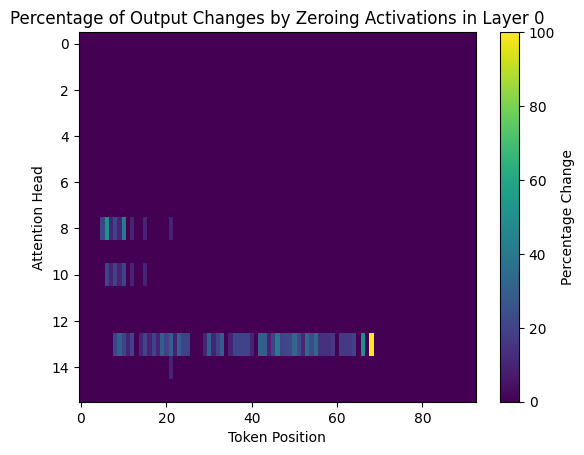

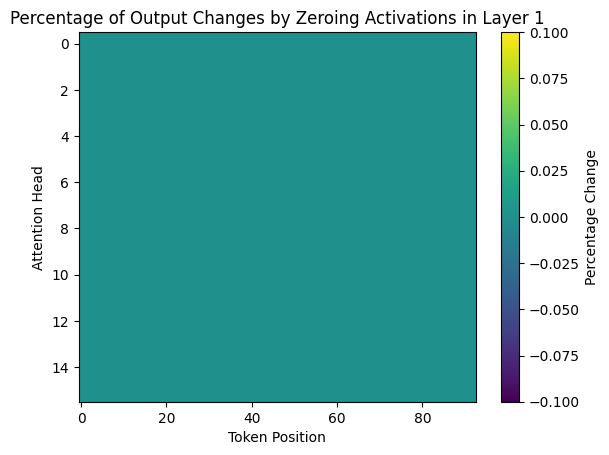

In [ ]:
for layer_idx in range(N_LAYERS):
    plt.imshow(g_attn_failure_rate[layer_idx], cmap="viridis", aspect="auto")
    plt.colorbar(label="Percentage Change")
    plt.xlabel("Token Position")
    plt.ylabel("Attention Head")
    plt.title("Percentage of Output Changes by Zeroing Activations in Layer " + str(layer_idx))
    plt.show()

In [ ]:
cfg.useful_nodes.print_node_tags()

P5L0H8 ['Fail%:20']
P6L0H10 ['Fail%:20']
P6L0H8 ['Fail%:50']
P7L0H10 ['Fail%:10']
P7L0H8 ['Fail%:10']
P8L0H10 ['Fail%:20']
P8L0H13 ['Fail%:20']
P8L0H8 ['Fail%:20']
P9L0H10 ['Fail%:10']
P9L0H13 ['Fail%:30']
P9L0H8 ['Fail%:10']
P10L0H10 ['Fail%:20']
P10L0H13 ['Fail%:20']
P10L0H8 ['Fail%:40']
P11L0H13 ['Fail%:10']
P12L0H10 ['Fail%:10']
P12L0H13 ['Fail%:20']
P12L0H8 ['Fail%:10']
P14L0H13 ['Fail%:10']
P15L0H10 ['Fail%:10']
P15L0H13 ['Fail%:20']
P15L0H8 ['Fail%:10']
P16L0H13 ['Fail%:10']
P17L0H13 ['Fail%:20']
P18L0H13 ['Fail%:10']
P19L0H13 ['Fail%:30']
P20L0H13 ['Fail%:20']
P21L0H13 ['Fail%:30']
P21L0H14 ['Fail%:10']
P21L0H8 ['Fail%:10']
P22L0H13 ['Fail%:10']
P23L0H13 ['Fail%:30']
P24L0H13 ['Fail%:20']
P25L0H13 ['Fail%:20']
P29L0H13 ['Fail%:10']
P30L0H13 ['Fail%:30']
P31L0H13 ['Fail%:10']
P32L0H13 ['Fail%:20']
P33L0H13 ['Fail%:30']
P35L0H13 ['Fail%:10']
P36L0H13 ['Fail%:20']
P37L0H13 ['Fail%:20']
P38L0H13 ['Fail%:20']
P39L0H13 ['Fail%:20']
P40L0H13 ['Fail%:10']
P42L0H13 ['Fail%:30']
P43L0H13

Saving quanta map: Useful attention heads


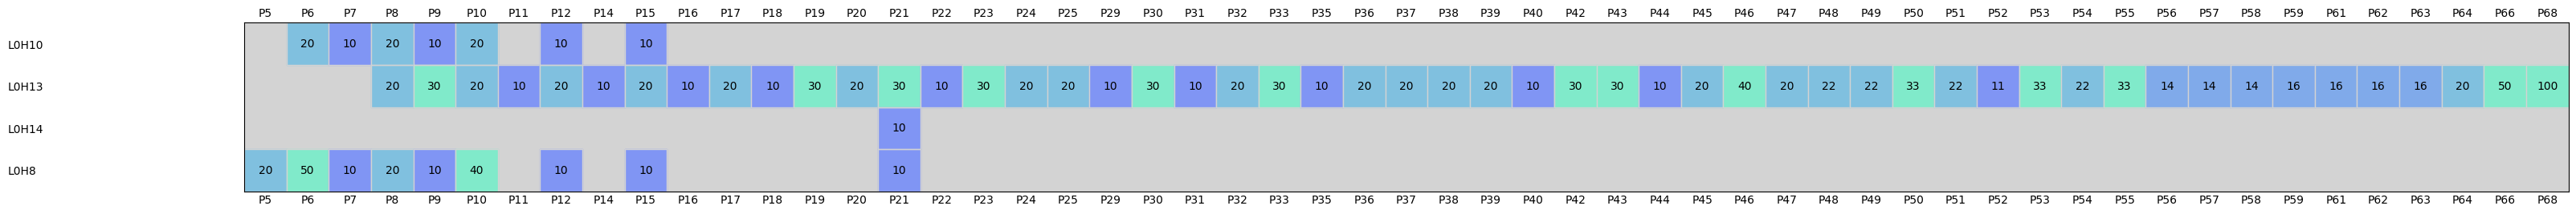

In [ ]:
title = "Useful attention heads"
ax1, quanta_results, num_results = qmi.calc_quanta_map(
    cfg, True, 6,
    cfg.useful_nodes, qmi.QType.FAIL.value, "", qmi.get_quanta_fail_perc,
    combine_identical_cells=False)

if num_results > 0:
    if cfg.graph_file_suffix > "":
        print("Saving quanta map:", title)
        qmi.save_plt_to_file(cfg=cfg, full_title=title)
    else:
        ax1.set_title(title + ' ({} nodes)'.format(len(quanta_results)))

    plt.show()

In [ ]:
# Serialize and save the useful nodes list to a temporary CoLab file in JSON format
main_fname_behavior_json = cfg.model_name + '_behavior.json'
print( "Saving useful node list with behavior tags:", main_fname_behavior_json)
cfg.useful_nodes.save_nodes(main_fname_behavior_json)

Saving useful node list with behavior tags: behavior.json


In [ ]:
# This notebook says:
m1_useful_layer_0_heads = [8,10,13,14]
m1_useful_layer_1_heads = []